# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [ ]:
def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    all_data = []

    for subject_id in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject_id)
        if not os.path.isdir(subject_path):
            continue

        for session in ['Final', 'Midterm 1', 'Midterm 2']:
            session_path = os.path.join(subject_path, session)
            if not os.path.isdir(session_path):
                continue

            try:
                hr_raw = pd.read_csv(os.path.join(session_path, 'HR.csv'), header=None)
                hr_start = hr_raw.iloc[0, 0]
                hr_values = hr_raw.iloc[1:, 0].astype(float).reset_index(drop=True)
                hr_timestamps = np.arange(hr_start, hr_start + len(hr_values))
                hr_df = pd.DataFrame({'timestamp': hr_timestamps, 'heart_rate': hr_values})

                eda_raw = pd.read_csv(os.path.join(session_path, 'EDA.csv'), header=None)
                eda_start = eda_raw.iloc[0, 0]
                eda_values = eda_raw.iloc[1:, 0].astype(float).reset_index(drop=True)
                eda_timestamps = eda_start + np.arange(len(eda_values)) / 4
                eda_df = pd.DataFrame({'timestamp': eda_timestamps, 'eda': eda_values})

                temp_raw = pd.read_csv(os.path.join(session_path, 'TEMP.csv'), header=None)
                temp_start = temp_raw.iloc[0, 0]
                temp_values = temp_raw.iloc[1:, 0].astype(float).reset_index(drop=True)
                temp_timestamps = temp_start + np.arange(len(temp_values)) / 4
                temp_df = pd.DataFrame({'timestamp': temp_timestamps, 'temperature': temp_values})

                df = pd.merge_asof(hr_df.sort_values('timestamp'), eda_df.sort_values('timestamp'), on='timestamp', direction='nearest')
                df = pd.merge_asof(df.sort_values('timestamp'), temp_df.sort_values('timestamp'), on='timestamp', direction='nearest')

                df['subject_id'] = subject_id
                df['session'] = session

                all_data.append(df)

            except Exception as e:
                print(f"Error processing {subject_id} - {session}: {e}")

    return pd.concat(all_data, ignore_index=True)


In [ ]:
df = load_data("/Users/jessica/4-it-s-about-time-hojess20/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data")  # complete the path
print(df.shape)
print(df.columns)
print(df.head(100))

(443032, 6)
Index(['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id',
       'session'],
      dtype='object')
       timestamp  heart_rate  eda  temperature subject_id session
0   1.544027e+09        1.00  0.0        21.67         S5   Final
1   1.544027e+09      118.00  0.0        21.65         S5   Final
2   1.544027e+09       84.50  0.0        21.65         S5   Final
3   1.544027e+09       97.67  0.0        21.67         S5   Final
4   1.544027e+09       85.25  0.0        21.65         S5   Final
..           ...         ...  ...          ...        ...     ...
95  1.544027e+09       98.38  0.0        22.01         S5   Final
96  1.544027e+09       97.95  0.0        22.03         S5   Final
97  1.544027e+09       97.47  0.0        22.05         S5   Final
98  1.544027e+09       97.07  0.0        22.01         S5   Final
99  1.544027e+09       96.72  0.0        22.05         S5   Final

[100 rows x 6 columns]
Shape: (443032, 6)
Subjects: ['S5' 'S2' 'S3' 'S4' 'S10' 'S8' 

## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [58]:
from scipy.stats import zscore
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Handle missing values: drop rows with any NaNs
    data = data.dropna()

    # 2. Resample to regular 1-second intervals per subject-session
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s', errors='coerce')
    resampled_data = []

    for (subject, session), group in data.groupby(['subject_id', 'session']):
        group = group.set_index('timestamp').sort_index()
        numeric_cols = group.select_dtypes(include='number').columns
        group_resampled = group[numeric_cols].resample('1S').mean().interpolate()
        group_resampled['subject_id'] = subject
        group_resampled['session'] = session
        resampled_data.append(group_resampled)

    data = pd.concat(resampled_data).reset_index()

    # 3. Remove outliers: z-score > 3
    for col in ['heart_rate', 'eda', 'temperature']:
        data = data[(np.abs(zscore(data[col])) < 3)]

    # 4. Save processed data to CSV
    output_path = os.path.join(output_dir, 'physiological_data_cleaned.csv')
    data.to_csv(output_path, index=False)

    return data

In [59]:
df_clean = preprocess_data(df)
print("Shape:", df_clean.shape)
print("Subjects:", df_clean['subject_id'].nunique())
print("Sessions:", df_clean['session'].unique())
print("Time range:", df_clean['timestamp'].min(), "to", df_clean['timestamp'].max())
print("Missing values?", df_clean.isna().sum())


/var/folders/m3/cjk44zyd71sd0l71hpnfvwwc0000gn/T/ipykernel_56976/3237132528.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  group_resampled = group[numeric_cols].resample('1S').mean().interpolate()
/var/folders/m3/cjk44zyd71sd0l71hpnfvwwc0000gn/T/ipykernel_56976/3237132528.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  group_resampled = group[numeric_cols].resample('1S').mean().interpolate()
/var/folders/m3/cjk44zyd71sd0l71hpnfvwwc0000gn/T/ipykernel_56976/3237132528.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  group_resampled = group[numeric_cols].resample('1S').mean().interpolate()
/var/folders/m3/cjk44zyd71sd0l71hpnfvwwc0000gn/T/ipykernel_56976/3237132528.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  group_resampled = group[numeric_cols].resample

Shape: (431049, 6)
Subjects: 10
Sessions: ['Final' 'Midterm 1' 'Midterm 2']
Time range: 2018-10-13 12:55:32 to 2018-12-05 23:39:16
Missing values? timestamp      0
heart_rate     0
eda            0
temperature    0
subject_id     0
session        0
dtype: int64


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [ ]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
# Filter data for the given subject and session
    subset = data[(data['subject_id'] == subject_id) & (data['session'] == session)]

    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # Plot Heart Rate
    axes[0].plot(subset['timestamp'], subset['heart_rate'], label='Heart Rate')
    axes[0].set_ylabel('Heart Rate (bpm)')
    axes[0].legend(loc='upper right')

    # Plot Electrodermal Activity
    axes[1].plot(subset['timestamp'], subset['eda'], label='EDA', color='orange')
    axes[1].set_ylabel('EDA (µS)')
    axes[1].legend(loc='upper right')

    # Plot Temperature
    axes[2].plot(subset['timestamp'], subset['temperature'], label='Temperature', color='green')
    axes[2].set_ylabel('Temperature (°C)')
    axes[2].set_xlabel('Time')
    axes[2].legend(loc='upper right')

    # Add main title
    fig.suptitle(f'Physiological Signals for {subject_id} during {session}', fontsize=14)

    # Format x-axis
    fig.autofmt_xdate()

    # Save plot to file
    plot_filename = f'{subject_id}_{session.replace(" ", "_")}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    fig.savefig(plot_path, bbox_inches='tight')

    return fig

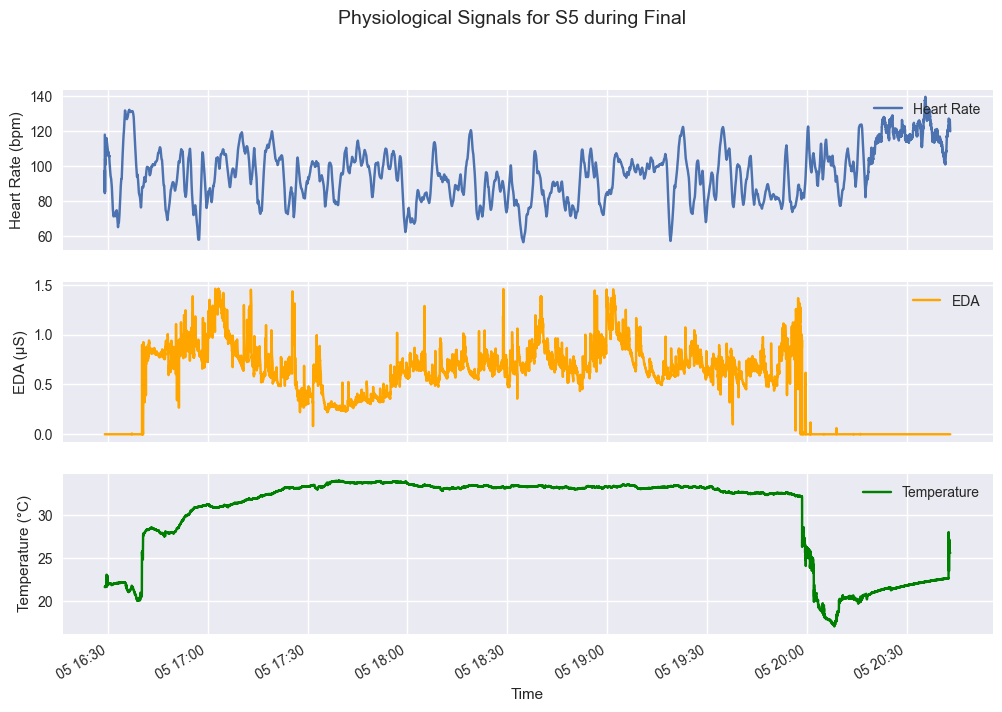

In [60]:
# Specific test subject and session
test_subject = 'S5'
test_session = 'Final'

# Plot physiological signals for S5 during Final exam
fig = plot_physiological_signals(df_clean, test_subject, test_session)

# Display the plot
plt.show()